Answer all questions and submit them either as an IPython notebook, LaTeX document, or Markdown document. Provide full answers for each question, including interpretation of the results. Each question is worth 25 points.

This homework is due on Monday, December 8, 2016.

## Question 1

The `titanic.xls` spreadsheet in the `data` directory contains data regarding the passengers on the Titanic when it sank in 1912. A recent [Kaggle competition](http://www.kaggle.com/c/titanic-gettingStarted) was based on predicting survival for passengers based on the attributes in the passenger list. 

Use scikit-learn to build both a support vector classifier and a logistic regression model to predict survival on the Titanic. Use cross-validation to assess your models, and try to tune them to improve performance.

Discuss the benefits and drawbacks of both approaches for application to such problems.

### Import packages

In [97]:
%matplotlib inline
import os
import random
import GPy
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import BaggingRegressor as br
from sklearn import tree
from sklearn import preprocessing
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [103]:
Penalty = 1000
lrmod = LogisticRegression(C = Penalty, n_jobs = -1) 
 
svc = svm.SVC(kernel='linear')

subsets = [['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked'],
           ['pclass', 'sex', 'age', 'parch', 'fare', 'embarked'],
           ['pclass', 'sex', 'parch', 'fare', 'embarked'],
           ['pclass', 'sex', 'fare', 'embarked'],
           ['pclass', 'sex', 'fare'],
           ['sex','pclass'],
          ['sex'],
          ['pclass'],
          ['fare'],
          ['embarked'],
          ['parch'],
          ['age'],
          ['sibsp'],
          ]

titanic = pd.read_excel(os.path.abspath(os.getcwd())+'/data/titanic.xls')

subset = titanic[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 
               'fare', 'embarked']].dropna()

y0 = subset.survived

X = subset[['age', 'fare']]
X0 = (X - X.mean(axis=0)) / X.std(axis=0)
X0['embarked'] = subset.embarked.replace({'C':0, 'S':1, 'Q':2})
X0['sex'] = subset.sex.replace({'female':0, 'male':1})
X0[['pclass', 'sibsp', 'parch']] = subset[['pclass', 'sibsp','parch']]

def kfold_cross_report(estimator, X , y, est_type, k=5, elements = subsets  ): 

    num_models = np.arange(len(elements ))
    k_fold_err = np.empty(len(elements ))

    for d in num_models:
        X0_sub = X0[ elements[d] ]
        error = np.empty(k)
    
        for j, fold in enumerate(KFold(n_splits=k,shuffle=True).split(X0_sub.values,y.values)):

            training, validation = fold
            x_train = X0_sub.values[training] 
            x_test =  X0_sub.values[training] 
            y_train =  y.values[training] 
            y_test =  y.values[validation] 
        
            estimator.fit(x_train, y_train)
        
            y_fit = estimator.predict(x_test)
        
            error[j] = mean_squared_error(y_true = y_train , y_pred = y_fit)
       
        k_fold_err[d] = error.mean()
        
    fig, ax = plt.subplots()
    ax.plot(k_fold_err, lw=2)
    ax.set_xlabel('Model Number',fontsize=15)
    ax.set_ylabel('average rms error',fontsize=15)
    ax.set_xticks([0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0])
    ax.set_title('position %d Fold Cross-Validation' % k)
    
    if est_type == 'LR':
        ax.set_title('Logistic Regression KFold Cross-Validation')
    if est_type == 'SVC':
        ax.set_title('Linear State Vector Machine KFold Cross-Validation')
        
    return
          
def learning_curve_reporter(estimator, est_type, X=X0.values, y=y0.values, train_vector=np.arange(60, 830, 10) ):
    
    scores = model_selection.cross_val_score(estimator, X, y, cv=10)
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                            train_sizes=train_vector, cv=20)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    f, ax = plt.subplots()
    ax.grid()
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    ax.legend(loc="best")
    
    if est_type == 'LR':
        print("Logistic Regression Model Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        ax.set_title('Logistic Regression Learning Curves',fontsize=15)
    if est_type == 'SVC':
        print("SVC Model Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        ax.set_title('Linear State Vector Machine Learning Curves',fontsize=15)
    if est_type == 'GBR':
        print("GBR Model Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        ax.set_title('Gradient Boosted Classifier Learning Curves',fontsize=15)    
        
    return
    
def predict_table(estimator, est_type, X=[subsets[0]], y=y0):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    estimator.fit(X_train,y_train)
    
    pred_train = estimator.predict(X_train)
    pred_test = estimator.predict(X_test)
    
    train_table = pd.crosstab(y_train, pred_train, rownames=["Actual"], colnames=["Predicted"])
    test_table = pd.crosstab(y_test, pred_test, rownames=['Actual'], colnames=['Predicted'])
    
    if est_type == 'LR':
        print('Logistic Regression Parameter Estimates:')
    if est_type == 'SVC':
        print('State Vector Machine Parameter Estimates:')
    
    for name, value in zip(X.columns, estimator.coef_[0]):
        print('{0}:\t{1:.2f}'.format(name, value))
    
    return train_table, test_table, estimator.score(X_test,y_test), estimator.score(X_test,y_test)    

The following KFold cross-validation scores test these models:

1: pclass, sex, age, sibsp, parch, fare, embarked
2: pclass, sex, age, parch, fare, embarked
3. pclass, sex, parch, fare, embarked
4. pclass, sex, fare, embarked
5. pclass, sex, fare
6. sex,pclass
7. sex
8. pclass
9. fare
10. embarked
11. parch
12. age
13. sibsp

Both KFold crossvalidation curves indicate that their is no appreciable difference bewteen the first 7 models. Hence out of the variables investigated sex was the dominant factor contributing to survival on the Titanic. Class also was 
a factor to a much lesser degree. Age however was not investigated.

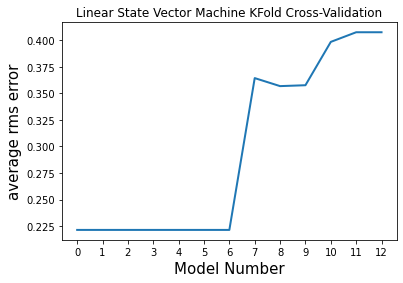

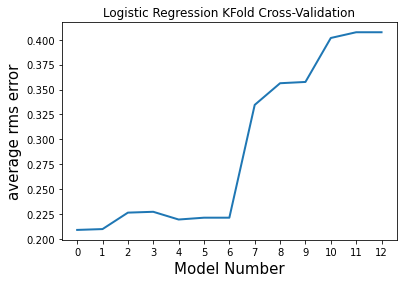

In [3]:
kfold_cross_report(svc, k = 25 , est_type = 'SVC', X= X0, y= y0)
kfold_cross_report(lrmod, k = 25 , est_type = 'LR', X= X0, y= y0)

I decided to evaluate how these models responded to increasingly larger data sets. It was clear that logisitic 
regression model benefited from training under data set larger that 200. While the state vector machine tended to be limited in benefits from larger training data sets.  However the SVC model has a better accuracy score relative to the
logistic regression model. 

Logistic Regression Model Accuracy: 0.74 (+/- 0.26)
SVC Model Accuracy: 0.78 (+/- 0.14)


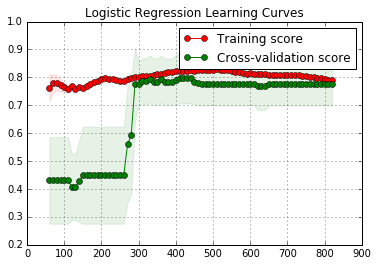

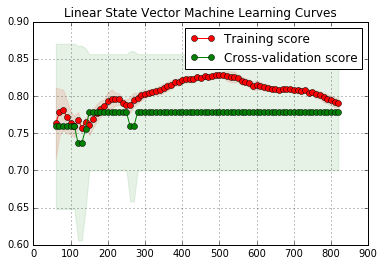

In [3]:
learning_curve_reporter(estimator = lrmod, X=X0[subsets[5]], est_type = 'LR' )
learning_curve_reporter(estimator =  svc, X=X0[subsets[5]], est_type = 'SVC' )

The most sensitive parameter was sex and pclass (as determined by the Kfold cross-validation curves above). This may also be inferred by the Lasso Ridge Cross-Validation scores. Based on the learning curves it is clear that for data sets greater than n = 60 the State Vector Machine and the Logistic Regression Model will be improved given more data.

In [4]:
[lrmodtrain_table, lrmodtest_table, lrmodtest_score, lrmodtrain_score] = predict_table(lrmod, 'LR', X0[subsets[5]], y0)
[svctrain_table, svctest_table, svctest_score, svctrain_score] = predict_table(svc,  'SVC', X0[subsets[5]], y0)

Logistic Regression Parameter Estimates:
sex:	-2.47
pclass:	-0.93
State Vector Machine Parameter Estimates:
sex:	-2.00
pclass:	0.00


### CV score 

Below is a plot of the CV score relative to the inverse of the regularization factor: C = 1/lambda

The max score is at C = 0.7420132499079867


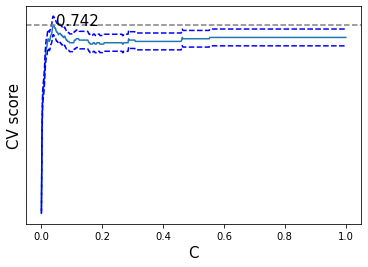

In [5]:
lambdas = np.linspace(0.001,1,500)
lrmod = LogisticRegression()
scores = np.empty(len(lambdas))
scores_std = np.empty(len(lambdas))

for i,lm_c in enumerate(lambdas):
    lrmod.C = lm_c
    s = model_selection.cross_val_score(lrmod, X0, y0, n_jobs=1)
    scores[i] = s.mean()
    scores_std[i] = s.std()
    
plt.plot(lambdas, scores)
plt.plot(lambdas, np.array(scores) + np.array(scores_std)/20, 'b--')
plt.plot(lambdas, np.array(scores) - np.array(scores_std)/20, 'b--')
plt.yticks(())
plt.ylabel('CV score',fontsize=15)
plt.xlabel('C',fontsize=15)
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.text(5e-2, np.max(scores)+1e-4, str(np.max(scores).round(3)),fontsize=15)

print('The max score is at C =' , np.max(scores))

### Retuned Logistic Regression has comparable accuracy to SVC

Now that we have tuned the logistic regression model, I again compare the logistic regression model against the SVC. The code below reruns the learning curve reporter funtion. And indeed it does. In fact the SVC and the logistic regression models have effectively the same accuracy score.

Logistic Regression Model Accuracy: 0.78 (+/- 0.14)
SVC Model Accuracy: 0.78 (+/- 0.14)


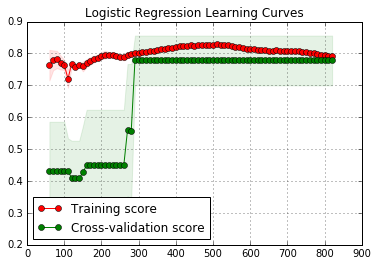

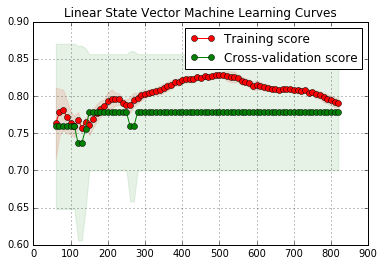

In [6]:
lrmod = LogisticRegression(C= np.max(scores))

learning_curve_reporter(estimator = lrmod, X=X0[subsets[5]], est_type = 'LR' )
learning_curve_reporter(estimator =  svc, X=X0[subsets[5]], est_type = 'SVC' )

## Question 2

The file `TNNASHVI.txt` in your data directory contains daily temperature readings for Nashville, courtesy of the [Average Daily Temperature Archive](http://academic.udayton.edu/kissock/http/Weather/). This data, as one would expect, oscillates annually. Using either GPy or PyMC#, use a Gaussian process to fit a non-parametric regression model to this data, choosing an appropriate covariance function. Plot 10 regression lines drawn from your process.

In [7]:
Sample_size = 1500

daily_temps = pd.read_table(os.path.abspath(os.getcwd())+'/data/TNNASHVI.txt', sep='\s+', 
                            names=['month','day','year','temp'], na_values=-99)

daily_temps = daily_temps.dropna()

n = np.shape(daily_temps)[0]
#daily_temps['x'] =np.r_[1:(daily_temps.shape[0]+1)]

N = range(n)
time = []
for i in N:
    time.append(float(i))
    
daily_temps['time'] = np.array(time)

grid = np.linspace(-.1*n,1.1*n,Sample_size)[:,None]

X_t, Y_t = daily_temps[ ['time', 'temp'] ].sample(n=Sample_size).sort_index().values.T

### Fit using a non-parametric Bayesian regression using a Gaussian process

 /Users/Matthew/anaconda3/envs/bios8366/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


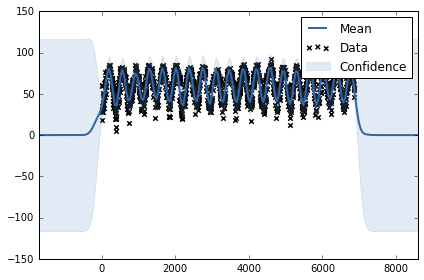

In [8]:
kernel = GPy.kern.RBF(1)

m = GPy.models.GPRegression(X=X_t[:,None], Y=Y_t[:,None],kernel=kernel)
m.optimize()
s2 = m.Gaussian_noise.variance[0]
m.plot()

I extract the mean and covariance matrix for the model and use these to draw 10 regression lines. These are plotted against the mean below. 

 /Users/Matthew/anaconda3/envs/bios8366/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning:covariance is not positive-semidefinite.


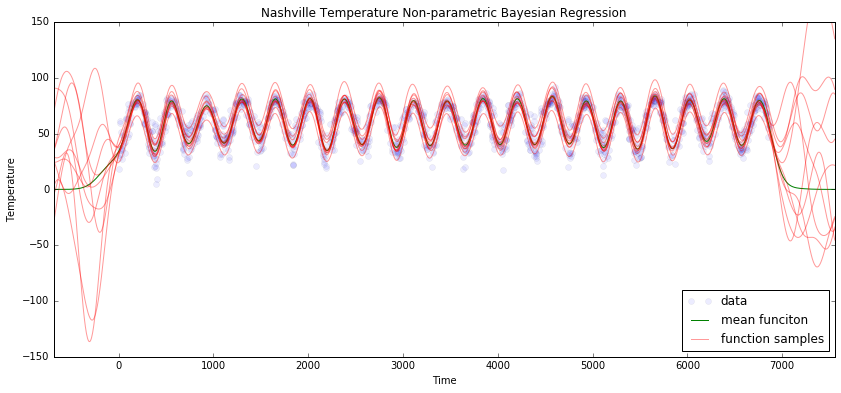

In [9]:
# extract mean  function and covariance matrix, posterior predictive of f is when s2 is not included
# extract mean  function and covariance matrix of y
mean_f, cov_f = m._raw_predict(grid, full_cov=True)
rv_posterior = sp.random.multivariate_normal(size = 10, mean = mean_f[:,0], cov = np.asarray(cov_f)+s2 )
plt.figure(figsize=(14,6))
plt.title('Nashville Temperature Non-parametric Bayesian Regression')
plt.ylabel('Temperature')
plt.xlabel('Time')
plt.xlim(-0.1*n,1.1*n)
plt.ylim(-150,150)
plt.plot(X_t,Y_t,"bo",alpha=0.075)
plt.plot(grid, mean_f, "g-", alpha = 1)
for draw in rv_posterior:
    plt.plot(grid[:,0], draw, "r-", alpha=.4)

plt.legend(['data','mean funciton', 'function samples'],loc='best')

## Question 3

The data in `prostate.data.txt` come from a study by Stamey et al. (1989), which examined the correlation between the level of prostate-specific antigen (`lpsa`) and a number of clinical measures in men who were about to receive a radical prostatectomy. The variables are log cancer volume (`lcavol`), log prostate weight (`lweight`), age, log of the amount of benign prostatic hyperplasia (`lbph`), seminal vesicle invasion (`svi`), log of capsular penetration (`lcp`), Gleason score (`gleason`), and percent of Gleason scores 4 or 5 (`pgg45`). 

1. Select (your choice) five competing 3-variable linear regression models, and compare them using AIC, five-fold and ten-fold cross-validation. Discuss the results.

2. An alternative method for model assessment is to fit the models on a set of bootstrap samples, and then keep track of how well it predicts the original training set. If $\hat{f}^b(x_i)$ is the predicted value at $x_i$, from the model fitted to the bth bootstrap dataset, such an estimate is:
$$\frac{1}{B} \frac{1}{N} \sum_{b=1}^B \sum_{i=1}^N L(y_i,\hat{f}^b(x_i)) $$
However, because the bootstrap samples tend to contain many observations in common among the set of bootstrap samples, this estimate will tend to underestimate the true error rate. The so-called .632 estimator aleviates this bias by returning a weighted average of the training error (average loss over the training sample) and the leave-one-out (LOO) bootstrap error:
$$\hat{err}^{(.632)} = 0.368 \, \bar{err} + 0.632 \, \hat{err}^{(1)}$$
where:
$$\bar{err} = \frac{1}{N}\sum_{i=1}^N L(y_i, \hat{f}(x_i)) $$
Repeat the assesment from part (1) using the .632 estimator, and compare the result to the other approaches.

### Comparison of five 3-variable models using AIC 

Text(0, 0.5, 'AIC')

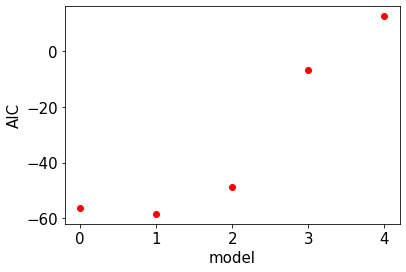

In [99]:
lnreg = LinearRegression()
aic = lambda rss, n, k: n*np.log(float(rss)/n) + 2*k

#Data wrangling - define data inputs and outputs, rescale
prostate_data = pd.read_table(os.path.abspath(os.getcwd())+'/data/prostate.data.txt').dropna()
lpsa = prostate_data['lpsa']
X = prostate_data[['lcavol', 'lweight', 'age', 'lbph', 'lcp','gleason','pgg45']]
# rescale inputs
X0 = (X - X.mean(axis=0)) / X.std(axis=0)
X0['train'] = prostate_data.train.replace({'F':0, 'T':1})

#subsets for different models
subsets = [['lcavol', 'lweight', 'age'],
           ['lcavol', 'lweight', 'pgg45'],
           ['lcavol', 'age', 'lbph'],
           ['lweight', 'pgg45', 'train'],
           ['lweight', 'lbph', 'train']]

k0 = len(subsets[0])
aic_values = np.zeros(len(subsets))
params = np.zeros((len(subsets), k0))

#calculate AIC
for i, s in enumerate(subsets):
    x = X0[s]
    y_prime = lpsa
    fit = lnreg.fit(y=y_prime, X=x)
    ss = ((fit.predict(x) - y_prime)**2).sum()
    n, k = x.shape
    aic_values[i] = aic(ss, n=n, k=k)
    #params[i, :len(s)] = fit.coef_
    
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.plot(aic_values, 'ro')
plt.xlabel('model',fontsize=15)
plt.gca().set_xticks(np.arange(5))
plt.ylabel('AIC',fontsize=15)

### Comparison of five 3-variable models using 5- and 10-fold cross-validation

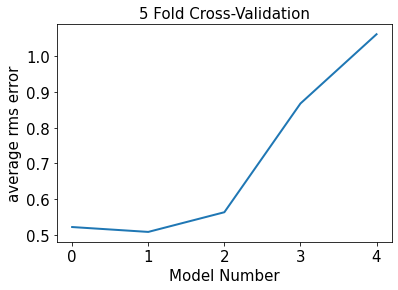

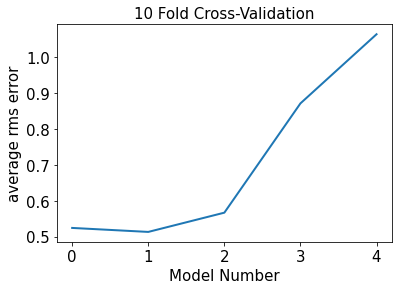

In [100]:
y0 = prostate_data['lpsa'].to_frame()
KFOLDS = [5,10]

def kfold_cross_reportQ3(k=5, elements = subsets, X=X0 , y = y0 , err_type = 0 ): 
#k = 5
    num_models = np.arange(len(elements ))
    k_fold_err = np.empty(len(elements ))

    for d in num_models:
        X0_sub = X0[ elements[d] ]
        error = np.empty(k)
    
        for j, fold in enumerate(KFold(n_splits=k, shuffle=True).split(X0_sub.values,y.values)):

            training, validation = fold
            x_train = np.asmatrix( X0_sub.values[training] )
            x_test = np.asmatrix( X0_sub.values[training] )
            y_train = np.asmatrix( y.values[training] )
            y_test = np.asmatrix( y.values[validation] )
        
            lnreg.fit(X = x_train, y = y_train)
        
            y_fit = lnreg.predict(x_test)
            
            if err_type == 0:
                error[j] = mean_squared_error(y_true = y_train , y_pred = y_fit)
                yLabel = 'average rms error'
            if err_type == 1:
                error[j] = r2_score(y_true = y_train , y_pred = y_fit)
                yLabel = '$R^2$'
       
        k_fold_err[d] = error.mean()
        
    fig, ax = plt.subplots()
    ax.plot(k_fold_err, lw=2)
    ax.set_xlabel('Model Number',fontsize=15)
    ax.set_ylabel(yLabel,fontsize=15)
    ax.set_xticks([0.0,1.0,2.0,3.0,4.0])
    ax.set_title('%d Fold Cross-Validation' % k,fontsize=15)
    
    return k_fold_err

kf_score = np.array([])
for i in KFOLDS:
    kf_score = kfold_cross_reportQ3(i)

#Report Mean Square Error for 5 and 10 fold kfolds

### Report the coefficient of determination, $R^2$ for 5 and 10 fold kfolds

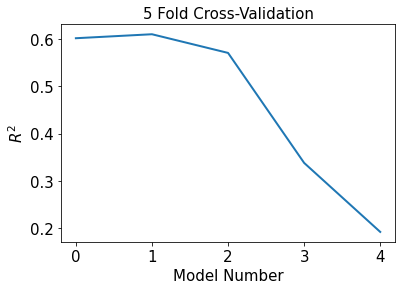

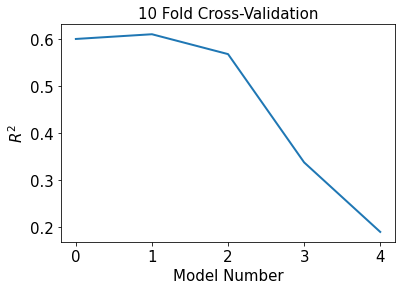

In [10]:
#Report R^2 for 5 and 10 fold kfolds
for i in KFOLDS:
    kf_score = kfold_cross_reportQ3(i,err_type=1)

In both cases model #1 was the best predictive performing model with the lowest prediction error, regardless of whether AIC or cross-validation was used. Also using AIC or k-fold cross-validation did not have an effect on how the models were ordered in terms of predictice error.

### Bootstrap Method

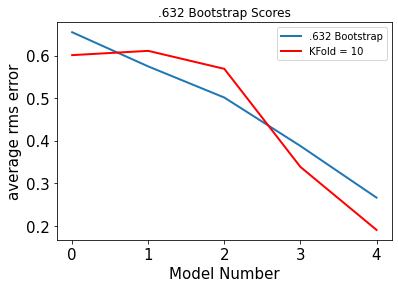

In [11]:
#This section uses the 0.632 bootstrap method for internal/cross validation
boot632= lambda test_error, boot1_error: 0.368*test_error + 0.632*boot1_error
        
Test_size = 0.4
Train_size = int( X0.values.shape[0]*(1-Test_size) )
t_size = np.arange(Train_size)

elements = subsets
num_models = np.arange(len(elements ))
bs_err = np.empty(len(elements ))

 
error = np.zeros(num_models.size) 
for d in num_models:
    X0_sub = X0[ elements[d] ]
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X0_sub.values , y0.values)   
    
    ensemble = br(base_estimator=LinearRegression(),
                                n_estimators=500,
                                max_samples=50,
                                bootstrap=True).fit(X_train, y_train[:,0])
    
    loo_score = ensemble.score(X_train,y_train)

    niave = br(base_estimator=LinearRegression(),
                                n_estimators=500,
                                max_samples=50,
                                bootstrap=True,
                                oob_score = True).fit(X_train, y_train[:,0])

  
    test_score = niave.score(X_train, y_train)
    error[d] = boot632(test_score,loo_score)

fig, ax = plt.subplots()
x = [0,1,2,3,4]
ax.plot(x, error, lw=2)
# plt.hold(True)
ax.plot(x, kf_score, lw=2, color = 'r')
ax.set_xlabel('Model Number',fontsize=15)
ax.set_ylabel('average rms error',fontsize=15)
ax.set_xticks([0.0,1.0,2.0,3.0,4.0])
ax.set_title('.632 Bootstrap Scores')
ax.legend(['.632 Bootstrap','KFold = 10'],loc='best')

The bootstrap method and the K-fold cross-validation generate similar predictions for the best performing models. Here model #1 was found to be the model with lowest predictive error. Also using AIC, k-fold cross-validation, or bootstrap  methods did not have an effect on how the models were ordered in terms of predictice error.



## Question 4

Fit a series of random-forest classifiers to the very low birthweight infant data (`vlbw.csv`), to explore the sensitivity to the parameter `m`, the number of variables considered for splitting at each step. Plot both the out-of-bag error as well as the test error against a suitably-chosen range of values for `m`.

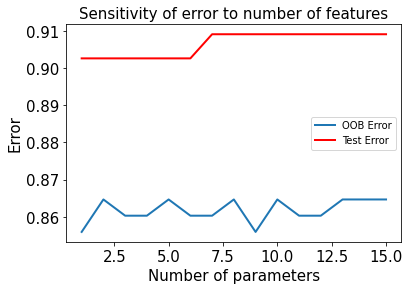

In [12]:
Trees = 1500
m = np.arange(15)+1
oob_score = []
test_score = [] 

vlbw = pd.read_csv(os.path.abspath(os.getcwd())+'/data/vlbw.csv', index_col=0)

vlbw = vlbw.replace({'inout':{'born at Duke':0, 'transported':1},
             'delivery':{'abdominal':0, 'vaginal':1},
             'ivh':{'absent':0, 'present':1, 'possible':1, 'definite':1},
             'sex':{'female':0, 'male':1}})

vlbw = vlbw[[u'birth', u'exit', u'hospstay', u'lowph', u'pltct', 
      u'bwt', u'gest', u'meth', 
      u'toc', u'delivery', u'apg1', u'vent', u'pneumo', u'pda', u'cld', 
      u'ivh']].dropna()

y = vlbw.pop('ivh').to_frame()
x = preprocessing.scale(vlbw)
X = pd.DataFrame(x, columns = vlbw.columns)

for i in m:
    
    rfc = RandomForestClassifier(n_estimators = Trees, max_features = i, 
                                 criterion = 'entropy',n_jobs = -1, oob_score=True, bootstrap=True)

    
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.4, random_state=0)

    rfc.fit(X_train, y_train.values[:,0])
    
    test_score.append( rfc.score(X_test, y_test.values[:,0]) )
    
    oob_score.append(rfc.oob_score_)
    i += 1


fig, ax = plt.subplots()
ax.plot(m,oob_score,lw=2)
ax.plot(m,test_score,lw=2, color = 'r')
ax.set_xlabel('Number of parameters',fontsize=15)
ax.set_ylabel('Error',fontsize=15)
ax.set_title('Sensitivity of error to number of features',fontsize=15)
ax.legend(['OOB Error','Test Error'],loc='best')

### Feauture Importance 

Feature ranking:
1. hospstay (0.168930)
2. pltct (0.149023)
3. lowph (0.113282)
4. bwt (0.100090)
5. gest (0.096436)
6. birth (0.095773)
7. exit (0.094839)
8. apg1 (0.083808)
9. pneumo (0.026266)
10. meth (0.017236)
11. delivery (0.016903)
12. pda (0.013554)
13. toc (0.009004)
14. cld (0.007485)
15. vent (0.007370)


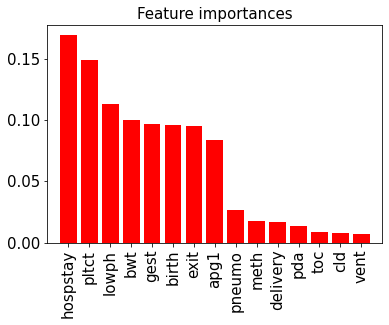

In [20]:
preds = rfc.predict(X_test)
pd.crosstab(y_test.values[:,0], preds, rownames=['actual'], 
            colnames=['prediction'])

importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))
    
plt.figure()
plt.title("Feature importances",fontsize='15')
plt.bar(range(X.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]]);

## Bonus: Question 5

Use a grid search to optimize the number of estimators and max_depth for a Gradient Boosted Decision tree using the very low birthweight infant data. Plug this optimal ``max_depth`` into a *single* decision tree.  Does this single tree over-fit or under-fit the data? Repeat this for the Random Forest.  Construct a single decision tree using the ``max_depth`` which is optimal for the Random Forest.  Does this single tree over-fit or under-fit the data?

### Grid search results

In [128]:
param_grid = {
              'max_depth': [4, 6, 8, 10, 12, 20, 30],
              
              'n_estimators': [100, 1000, 2000, 5000] 
              }

X_train, X_test, y_train, y_test = model_selection.train_test_split(X0, y0, test_size=0.4, random_state=0)

est = GradientBoostingRegressor(n_estimators=3000)

# this may take some minutes
gs_cv = GridSearchCV(est, param_grid, n_jobs=1).fit(X_train, y_train)
gs_cv.best_params_

# best hyperparameter setting
gs_cv.best_params_

{'max_depth': 4, 'n_estimators': 100}

### A single Tree underfits the data

This is evidenced by the fact that the training and cross-validation curves are relatively flat.

GBR Model Accuracy: 0.32 (+/- 0.38)


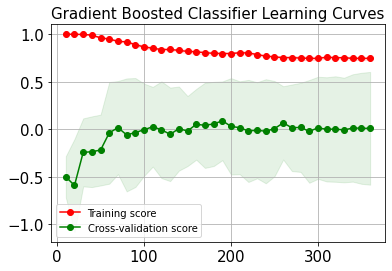

In [148]:
est = GradientBoostingRegressor(max_depth=4, n_estimators = 1)
est.fit(  X_train,y_train.values.T)

preds = np.round ( est.predict(X_test) )
confusion_matrix(y_test,preds)
#The output underfits

learning_curve_reporter(estimator = GradientBoostingRegressor(), 
                        X=X0,
                        y=y0 
                        ,train_vector=np.arange(10,363,10), 
                        est_type = 'GBR')

### A single tree underfits the data for a random forest classifier

This is evidenced by the fact that the training and cross-validation curves are relatively flat.

GBR Model Accuracy: 0.73 (+/- 0.20)


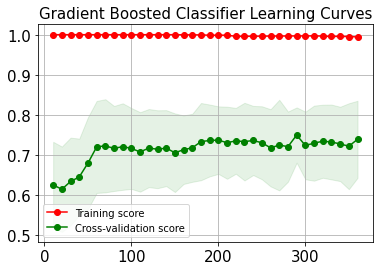

In [149]:
rf = RandomForestClassifier(n_jobs=1,
                            n_estimators = 1,
                            max_features="auto",
                                  min_samples_leaf=10,
                                  max_depth=4)
rf.fit(X_train,y_train.values.T)
preds = rf.predict(X_test)

learning_curve_reporter(estimator = RandomForestClassifier(), 
                        X=X0,
                        y=y0 
                        ,train_vector=np.arange(10,363,10), 
                        est_type = 'GBR')